In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(0)

periods = 60
t = np.arange(periods)

sales = 50 + 0.8 * t + 10 * np.sin(2 * np.pi * t / 12) + np.random.normal(scale=5, size=periods)

df = pd.DataFrame({
    'month': pd.date_range('2020-01-01', periods=periods, freq='M'),
    'sales': sales
})

# Linear trend model
X = sm.add_constant(np.arange(len(df)))
model = sm.OLS(df['sales'], X).fit()
print(model.summary())

# Predict next 6 months
future_t = np.arange(len(df), len(df) + 6)
future_X = sm.add_constant(future_t)
pred = model.get_prediction(future_X)
print(pred.summary_frame(alpha=0.05))


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     82.48
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           9.72e-13
Time:                        16:29:50   Log-Likelihood:                -217.83
No. Observations:                  60   AIC:                             439.7
Df Residuals:                      58   BIC:                             443.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.4389      2.368     23.414      0.0

C:\Users\BC\AppData\Local\Temp\ipykernel_3372\2547118037.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'month': pd.date_range('2020-01-01', periods=periods, freq='M'),


seasonal var: 66.8463963463102 resid var: 22.554129270995542


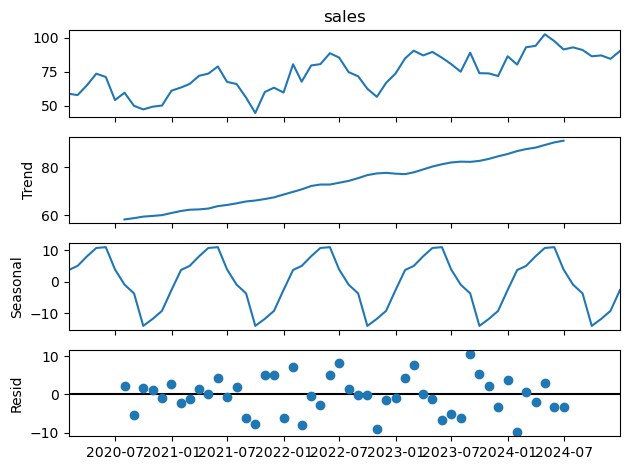

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df.set_index('month')['sales'], model='additive', period=12)
res.plot()

seasonal_var = res.seasonal.var()
resid_var = res.resid.dropna().var()
print("seasonal var:", seasonal_var, "resid var:", resid_var)


In [3]:
last_year = df['sales'].iloc[-12:].values
S = 10000

samples = np.random.choice(last_year, size=(S, 3), replace=True)
quarter_totals = samples.sum(axis=1)

print("expected quarterly revenue:", quarter_totals.mean())
print("95% interval:", np.percentile(quarter_totals, [2.5, 97.5]))


expected quarterly revenue: 273.10787973171335
95% interval: [253.79732012 292.58138447]


In [4]:
from scipy import stats

df['period'] = np.where(np.arange(len(df)) < 36, 'before', 'after')

# One-sample
t1, p1 = stats.ttest_1samp(df['sales'], popmean=60)

# Two-sample
before = df[df['period']=='before']['sales']
after = df[df['period']=='after']['sales']
t2, p2 = stats.ttest_ind(before, after, equal_var=False)

t1, p1, t2, p2


(np.float64(7.5597814879050835),
 np.float64(3.045353994035238e-10),
 np.float64(-8.766046053247784),
 np.float64(3.3164867138353755e-12))

In [5]:
np.random.seed(1)
marketing = 5 + 0.5*np.arange(len(df)) + np.random.normal(scale=3, size=len(df))
df["marketing"] = marketing

X = sm.add_constant(df["marketing"])
mod = sm.OLS(df["sales"], X).fit()
print(mod.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     74.33
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           5.62e-12
Time:                        16:55:48   Log-Likelihood:                -219.62
No. Observations:                  60   AIC:                             443.2
Df Residuals:                      58   BIC:                             447.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.8090      2.853     18.158      0.0

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Month dummies
df['monthnum'] = df['month'].dt.month
dummies = pd.get_dummies(df['monthnum'], prefix='m', drop_first=True)

# Build X (marketing + month dummies)
X = pd.concat([df['marketing'], dummies], axis=1)

# Add constant
X2 = sm.add_constant(X)

# Ensure numeric
X2 = X2.astype(float)

# SAFE VIF CALCULATION (never crashes)
def safe_vif(df):
    from numpy.linalg import LinAlgError
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    vif_values = []
    for i in range(df.shape[1]):
        try:
            vif = variance_inflation_factor(df.values, i)
        except (LinAlgError, ValueError, TypeError):
            vif = np.inf   # means perfect multicollinearity
        vif_values.append(vif)
    return pd.Series(vif_values, index=df.columns)

vifs = safe_vif(X2)
print(vifs)

# Fit model safely (statsmodels automatically handles collinearity)
model = sm.OLS(df['sales'], X2).fit()
print(model.summary())


const        15.694573
marketing     1.060603
m_2           1.833799
m_3           1.836060
m_4           1.833990
m_5           1.833814
m_6           1.833610
m_7           1.838338
m_8           1.846300
m_9           1.841043
m_10          1.847588
m_11          1.861288
m_12          1.861768
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     38.37
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           3.54e-20
Time:                        17:04:11   Log-Likelihood:                -172.98
No. Observations:                  60   AIC:                             372.0
Df Residuals:                      47   BIC:                             399.2
Df Model:                          12                 

In [13]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

# FIX for your error
df["t"] = np.arange(len(df))  # recreate missing column

features = ["t", "marketing"]
X = df[features].values
y = df["sales"].values

lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)

scores = -cross_val_score(lr, X, y, cv=tscv, scoring="neg_root_mean_squared_error")

print("CV RMSEs:", scores)
print("Mean RMSE:", scores.mean())


CV RMSEs: [26.96559374 12.84960715 10.41061511  7.0161042   8.35211606]
Mean RMSE: 13.11880725242006


In [14]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

X = df[['t','marketing']].values
y = df['sales'].values

lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)

scores = -cross_val_score(lr, X, y, cv=tscv, scoring='neg_root_mean_squared_error')
print(scores)
print(scores.mean())


[26.96559374 12.84960715 10.41061511  7.0161042   8.35211606]
13.11880725242006


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     38.37
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           3.54e-20
Time:                        17:10:50   Log-Likelihood:                -172.98
No. Observations:                  60   AIC:                             372.0
Df Residuals:                      47   BIC:                             399.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.7064      2.499     20.294      0.0

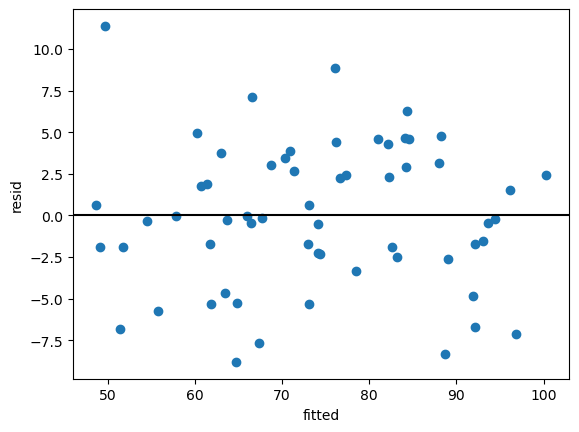

In [15]:
print(model.summary())

cols = [c for c in X2.columns if c.startswith('m_')]
R = np.zeros((len(cols), len(X2.columns)))

for i, c in enumerate(cols):
    R[i, X2.columns.get_loc(c)] = 1

f_test = model.f_test(R)
print(f_test)

import matplotlib.pyplot as plt
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='k')
plt.xlabel('fitted'); plt.ylabel('resid');


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X = df[['t','marketing']]
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

# bootstrap
resid = y_train - pipe.predict(X_train)
B = 1000
boot_preds = np.zeros((B, len(X_test)))

for b in range(B):
    res_sample = np.random.choice(resid, size=len(y_train), replace=True)
    y_prime = pipe.predict(X_train) + res_sample

    m = Ridge(alpha=1.0)
    Xtrain_scaled = StandardScaler().fit_transform(X_train)
    m.fit(Xtrain_scaled, y_prime)

    Xtest_scaled = StandardScaler().fit_transform(X_test)
    boot_preds[b] = m.predict(Xtest_scaled)

pi_lower = np.percentile(boot_preds, 2.5, axis=0)
pi_upper = np.percentile(boot_preds, 97.5, axis=0)

for i, (p, lo, hi) in enumerate(zip(preds, pi_lower, pi_upper)):
    print(f'idx {i}: pred={p:.2f}, 95% PI=({lo:.2f}, {hi:.2f})')


idx 0: pred=83.47, 95% PI=(53.94, 64.71)
idx 1: pred=84.76, 95% PI=(56.73, 69.29)
idx 2: pred=84.84, 95% PI=(59.33, 67.97)
idx 3: pred=84.41, 95% PI=(59.69, 66.57)
idx 4: pred=83.78, 95% PI=(54.48, 69.41)
idx 5: pred=85.52, 95% PI=(62.79, 70.64)
idx 6: pred=86.28, 95% PI=(65.47, 72.76)
idx 7: pred=88.02, 95% PI=(70.57, 77.28)
idx 8: pred=88.95, 95% PI=(72.69, 80.91)
idx 9: pred=89.64, 95% PI=(74.41, 83.38)
idx 10: pred=89.23, 95% PI=(73.33, 82.78)
idx 11: pred=90.67, 95% PI=(77.00, 87.45)
